In [1]:
# installed manually via pip3, with no version constraints
import pickle
import google.cloud
import pandas as pd
import pyarrow.parquet as pq
import scipy.stats as stats
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
import shap
import matplotlib.pyplot as plt


# Helper functions

In [3]:
def process_data(parquet_folder, columns_to_keep, target_label):
    print("importing parquet")
    df = pq.read_table(parquet_folder)
    print("converting to pandas")
    df = df.to_pandas()
    
    print("subset only needed columns")
    df = df[columns_to_keep]
    
    print("cast these to float, not sure why they were objects")
    df["subcat_spend_proportion"] = df["subcat_spend_proportion"].astype(float)
    df["f01_mem_8wk_spent"] = df["f01_mem_8wk_spent"].astype(float)
    
    print("add dummy random variable")
    df['random_number'] = np.random.rand(df.shape[0])
    
    print("OHE")
    df = pd.get_dummies(df)
    
    print("separating out label")
    X = df.drop([target_label],axis=1)
    column_labels = X.columns  # save column labels
    y = df[target_label]
    
    return X, y, column_labels

In [23]:
def plot_ROC_AUC(y_true, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [38]:
def plot_shap_importance(model, X_train, column_labels):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, features=X_train, feature_names=column_labels, plot_type="bar", max_display=50)


# Grab data from GCS

In [2]:
# !gsutil -m cp gs://wx-e1710759-2e30-40b2-a876-11588a57cb50/wx-prod-re/splo-training-dev/censuspca/full_retrain/H/*.parquet AKL_data/censuspca/full_retrain/H
# !gsutil -m cp gs://wx-e1710759-2e30-40b2-a876-11588a57cb50/wx-prod-re/splo-training-dev/censuspca/full_retrain/M/*.parquet AKL_data/censuspca/full_retrain/M
# !gsutil -m cp gs://wx-e1710759-2e30-40b2-a876-11588a57cb50/wx-prod-re/splo-training-dev/censuspca/full_retrain/V/*.parquet AKL_data/censuspca/full_retrain/V

# Train on "H" holdout data only

In [56]:
# features used in the incumbent model plus the PCA census factors
COLUMNS_TO_KEEP = ['f01_mem_segment_cvm',
                   'basket_presence_sgmnt_crn',
                   'basket_presence_article_sgmnt',
                   'cov_basketsize_nos_subcat',
                   'cov_visit_freq_subcat',
                   'item_score',
                   'num_purch_6m',
                   'num_purch_6m_sgmnt',
                   'num_purch_indicator',
                   'ratio_price_to_median',
                   'subcat_spend_proportion',
                   'visit_art_sgmnt_score',
                   'visit_art_subcat_score',
                   'visit_article_score',
                   'visit_subcat_score',
                   'f01_mem_8wk_spent',
                    'PCA_1',
                    'PCA_2',
                    'PCA_3',
                    'PCA_4',
                    'PCA_5',
                    'PCA_6',
                    'PCA_7',
                    'PCA_8',
                    'PCA_9',
                    'PCA_10',
                    'PCA_11',
                    'PCA_12',
                    'PCA_13',
                    'PCA_14',
                    'PCA_15',
                    'PCA_16',
                    'PCA_17',
                    'PCA_18',
                    'PCA_19',
                    'PCA_20',
                    'PCA_21',
                    'PCA_22',
                    'PCA_23',
                    'PCA_24',
                    'PCA_25',
                    'PCA_26',
                    'PCA_27',
                    'PCA_28',
                    'PCA_29',
                    'PCA_30',
                   'label'
                  ]
print("Processing data")
X, y, X_column_labels = process_data(parquet_folder='AKL_data/censuspca/full_retrain/H', columns_to_keep=COLUMNS_TO_KEEP, target_label="label")

Processing data
importing parquet
converting to pandas
subset only needed columns
cast these to float, not sure why they were objects
add dummy random variable
OHE
separating out label


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

del X, y  # clear RAM

## Holdout only XGB

In [58]:
# fit model no training data
model_xgb = XGBClassifier(n_jobs=-1)
model_xgb.fit(X_train, y_train, eval_metric="error", eval_set=[(X_valid, y_valid)], verbose=True)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-error:0.00681
[1]	validation_0-error:0.00668
[2]	validation_0-error:0.00664
[3]	validation_0-error:0.00661
[4]	validation_0-error:0.00661
[5]	validation_0-error:0.00658
[6]	validation_0-error:0.00660
[7]	validation_0-error:0.00659
[8]	validation_0-error:0.00657
[9]	validation_0-error:0.00657
[10]	validation_0-error:0.00658
[11]	validation_0-error:0.00656
[12]	validation_0-error:0.00656
[13]	validation_0-error:0.00657
[14]	validation_0-error:0.00656
[15]	validation_0-error:0.00656
[16]	validation_0-error:0.00656
[17]	validation_0-error:0.00654
[18]	validation_0-error:0.00654
[19]	validation_0-error:0.00655
[20]	validation_0-error:0.00654
[21]	validation_0-error:0.00654
[22]	validation_0-error:0.00654
[23]	validation_0-error:0.00655
[24]	validation_0-error:0.00655
[25]	validation_0-error:0.00656
[26]	validation_0-error:0.00655
[27]	validation_0-error:0.00655
[28]	validation_0-error:0.00656
[29]	validation_0-error:0.00656
[30]	validation_0-error:0.00656
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [59]:
# make predictions for test data
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.33%


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


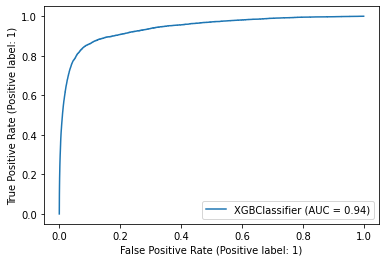

In [60]:
metrics.plot_roc_curve(model_xgb, X_test, y_test) 
plt.show()

In [61]:
df_feature_importance = pd.DataFrame({"column":X_column_labels, "feature_importances_":model_xgb.feature_importances_}).sort_values(by=["feature_importances_"],                                                                                                                           ascending=False)
df_feature_importance

column  feature_importances_
7             num_purch_indicator              0.496029
5                    num_purch_6m              0.249780
1   basket_presence_article_sgmnt              0.082727
12            visit_article_score              0.030212
46     f01_mem_segment_cvm_HVHIGH              0.015584
0       basket_presence_sgmnt_crn              0.008291
11         visit_art_subcat_score              0.005302
4                      item_score              0.004607
57     f01_mem_segment_cvm_MVMEDB              0.003664
14              f01_mem_8wk_spent              0.003444
8           ratio_price_to_median              0.003300
10          visit_art_sgmnt_score              0.003299
9         subcat_spend_proportion              0.003283
6              num_purch_6m_sgmnt              0.003158
3           cov_visit_freq_subcat              0.002717
55     f01_mem_segment_cvm_MVHIGH              0.002595
47      f01_mem_segment_cvm_HVMED              0.002444
27                         PCA_13              0.002440
44                         PCA_30              0.002320
2       cov_basketsize_nos_subcat              0.002295
37                         PCA_23              0.002268
52      f01_mem_segment_cvm_LVHFB              0.002248
30                         PCA_16              0.002240
28                         PCA_14              0.002218
41                         PCA_27              0.002208
25                         PCA_11              0.002176
39                         PCA_25              0.002163
33                         PCA_19              0.002162
31                         PCA_17              0.002158
29                         PCA_15              0.002155
42                         PCA_28              0.002152
16                          PCA_2              0.002131
35                         PCA_21              0.002131
13             visit_subcat_score              0.002128
40                         PCA_26              0.002126
51      f01_mem_segment_cvm_LVHFA              0.002124
38                         PCA_24              0.002120
18                          PCA_4              0.002102
19                          PCA_5              0.002101
21                          PCA_7              0.002098
17                          PCA_3              0.002094
34                         PCA_20              0.002090
32                         PCA_18              0.002064
20                          PCA_6              0.002042
53       f01_mem_segment_cvm_LVLF              0.002041
50        f01_mem_segment_cvm_LOW              0.002016
23                          PCA_9              0.002005
22                          PCA_8              0.001952
24                         PCA_10              0.001907
43                         PCA_29              0.001894
15                          PCA_1              0.001891
36                         PCA_22              0.001853
26                         PCA_12              0.001846
45                  random_number              0.001826
56     f01_mem_segment_cvm_MVMEDA              0.001077
54      f01_mem_segment_cvm_LVLFB              0.000702
49     f01_mem_segment_cvm_LAPSED              0.000000
48   f01_mem_segment_cvm_INACTIVE              0.000000

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


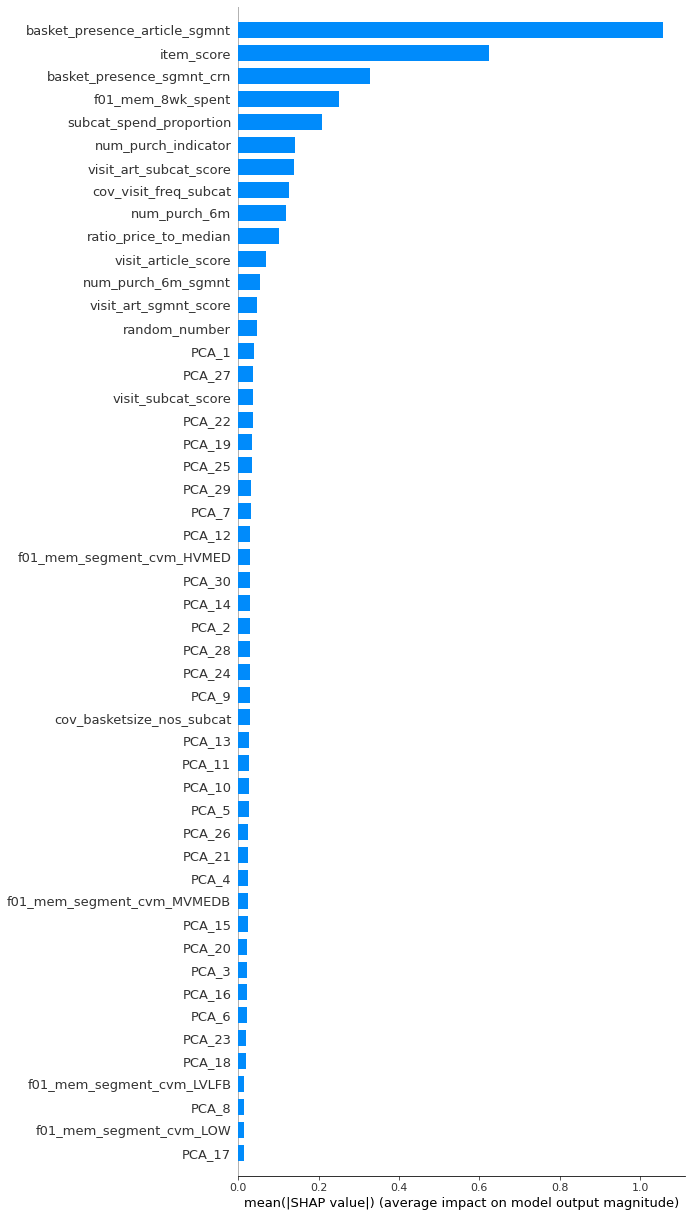

In [64]:
plot_shap_importance(model_xgb, X_train, X_column_labels)    

## Holdout only LGBM

In [65]:
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_valid, label=y_valid)
test_data = lgb.Dataset(X_test, label=y_test)

In [66]:
param = {'objective': 'binary', 'metric':['auc', 'binary_logloss']}
num_round = 1000
model_lgb = lgb.train(param, train_data, num_round, valid_sets=validation_data, callbacks=[lgb.early_stopping(stopping_rounds=15)])

[LightGBM] [Info] Number of positive: 14133, number of negative: 2017432
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10958
[LightGBM] [Info] Number of data points in the train set: 2031565, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006957 -> initscore=-4.961068
[LightGBM] [Info] Start training from score -4.961068
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.936938	valid_0's binary_logloss: 0.0258802


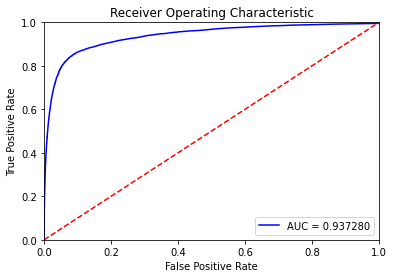

In [67]:
plot_ROC_AUC(y_test, model_lgb.predict(X_test))

In [ ]:
# AUC precision-recall curve

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

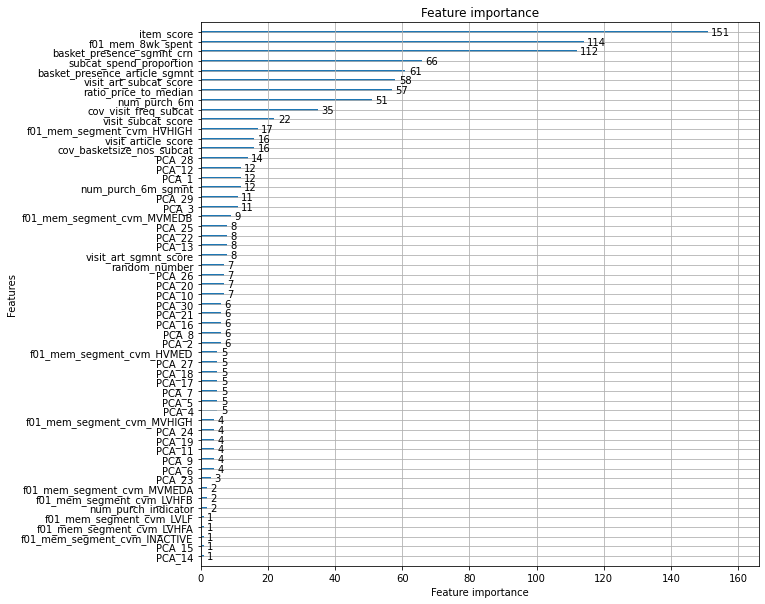

In [68]:
lgb.plot_importance(model_lgb,figsize=(10, 10))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


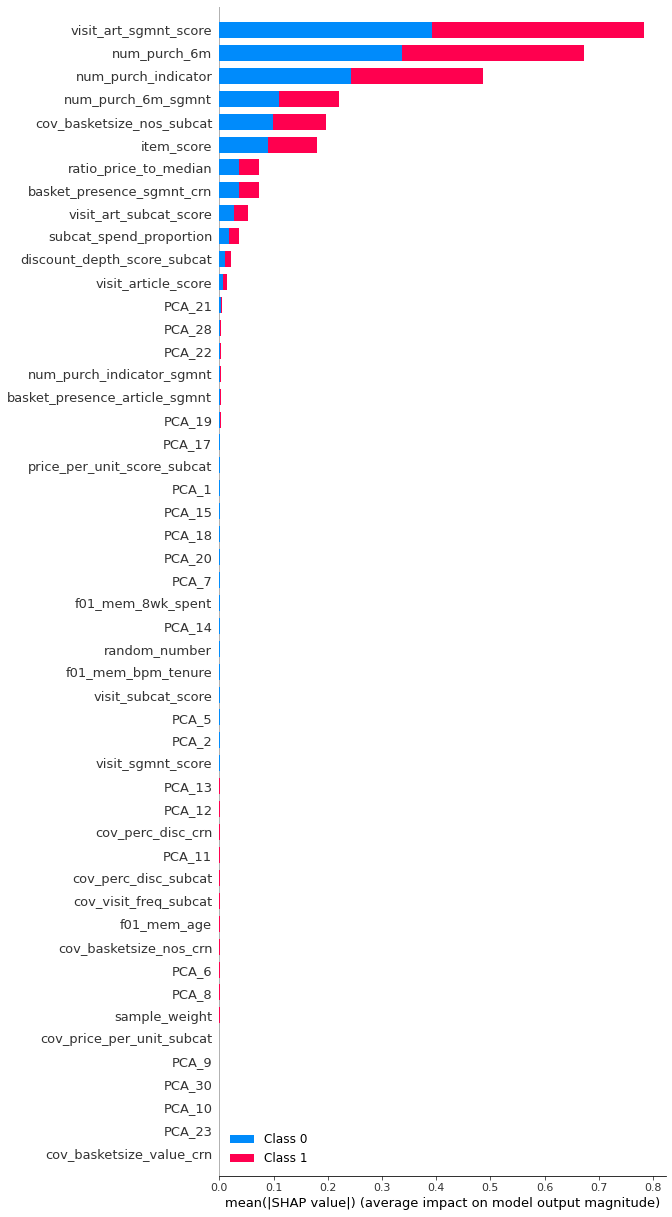

In [70]:
plot_shap_importance(model_lgb, X_train, X_train_column_labels)    

# Replicate exact AKL final retrain

In [71]:
# AKL PCA census model features PLUS PCA features
COLUMNS_TO_KEEP = ['num_purch_indicator',
                    'num_purch_6m',
                    'basket_presence_article_sgmnt',
                    'visit_article_score',
                    'visit_art_sgmnt_score',
                    'item_score',
                    'ratio_price_to_median',
                    'basket_presence_sgmnt_crn',
                    'visit_art_subcat_score',
                    'num_purch_6m_sgmnt',
                    'f01_mem_segment_cvm',
                    'f01_mem_8wk_spent',
                    'subcat_spend_proportion',
                    'discount_depth_score_subcat',
                    'num_purch_indicator_sgmnt',
                    'cov_basketsize_nos_subcat',
                    'cov_perc_disc_subcat',
                    'cov_visit_freq_subcat',
                    'f01_mem_bpm_tenure',
                    'visit_sgmnt_score',
                    'visit_subcat_score',
                    'price_per_unit_score_subcat',
                    'cov_price_per_unit_subcat',
                    'f01_mem_age',
                    'cov_basketsize_value_crn',
                    'cov_perc_disc_crn',
                    'cov_basketsize_nos_crn',
                    'PCA_1',
                    'PCA_2',
                    'PCA_3',
                    'PCA_4',
                    'PCA_5',
                    'PCA_6',
                    'PCA_7',
                    'PCA_8',
                    'PCA_9',
                    'PCA_10',
                    'PCA_11',
                    'PCA_12',
                    'PCA_13',
                    'PCA_14',
                    'PCA_15',
                    'PCA_16',
                    'PCA_17',
                    'PCA_18',
                    'PCA_19',
                    'PCA_20',
                    'PCA_21',
                    'PCA_22',
                    'PCA_23',
                    'PCA_24',
                    'PCA_25',
                    'PCA_26',
                    'PCA_27',
                    'PCA_28',
                    'PCA_29',
                    'PCA_30',
                   'label',
                   'sample_weight'
                  ]
print("Processing train data")
X_train, y_train, X_train_column_labels = process_data(parquet_folder='AKL_data/censuspca/full_retrain/M',
                                                 columns_to_keep=COLUMNS_TO_KEEP, target_label="label")
print("Processing valid data")
X_valid, y_valid, X_valid_column_labels = process_data(parquet_folder='AKL_data/censuspca/full_retrain/V',
                                                 columns_to_keep=COLUMNS_TO_KEEP, target_label="label")
print("Processing test data")
X_test, y_test, X_test_column_labels = process_data(parquet_folder='AKL_data/censuspca/full_retrain/H',
                                                 columns_to_keep=COLUMNS_TO_KEEP, target_label="label")

Processing train data
importing parquet
converting to pandas
subset only needed columns
cast these to float, not sure why they were objects
add dummy random variable
OHE
separating out label
Processing valid data
importing parquet
converting to pandas
subset only needed columns
cast these to float, not sure why they were objects
add dummy random variable
OHE
separating out label
Processing test data
importing parquet
converting to pandas
subset only needed columns
cast these to float, not sure why they were objects
add dummy random variable
OHE
separating out label


In [33]:
# convert to LGBM datasets
train_data = lgb.Dataset(X_train.drop("sample_weight", axis="columns"), label=y_train, weight=X_train.sample_weight)
valid_data = lgb.Dataset(X_valid.drop("sample_weight", axis="columns"), label=y_valid, weight=X_valid.sample_weight)
test_data = lgb.Dataset(X_test.drop("sample_weight", axis="columns"), label=y_test, weight=X_train.sample_weight)

## Match AKL hyper parameters

In [34]:
# train with AKL hyper params
# gs://wx-e1710759-2e30-40b2-a876-11588a57cb50/wx-prod-re/splo-training-dev/censuspca/20220502053619/model_selector/best_hyperparameters.json

best_hyperparams = {"bagging_fraction": 0.5, "boosting_type": "gbdt", "first_metric_only": True, "learning_rate": 0.01, "max_depth": 5, "min_child_samples": 5000, "n_estimators": 150, "n_jobs": -1, "num_leaves": 20, "random_seed": 399, "reg_alpha": 5, "reg_lambda": 2, "sub_feature": 0.5, "subsample_freq": 2}

# param = {'objective': 'binary', 'metric':['auc', 'binary_logloss']}
# num_round = 1000


model_lgb_AKL = lgb.train(best_hyperparams, train_data)


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.359473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13312
[LightGBM] [Info] Number of data points in the train set: 15999044, number of used features: 69
[LightGBM] [Info] Start training from score 0.007869


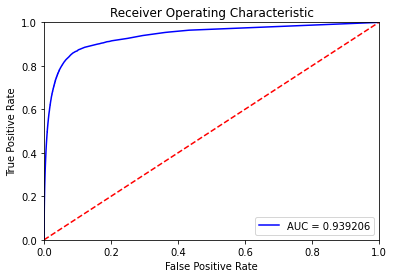

In [36]:
plot_ROC_AUC(y_test, model_lgb_AKL.predict(X_test.drop("sample_weight", axis="columns")))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


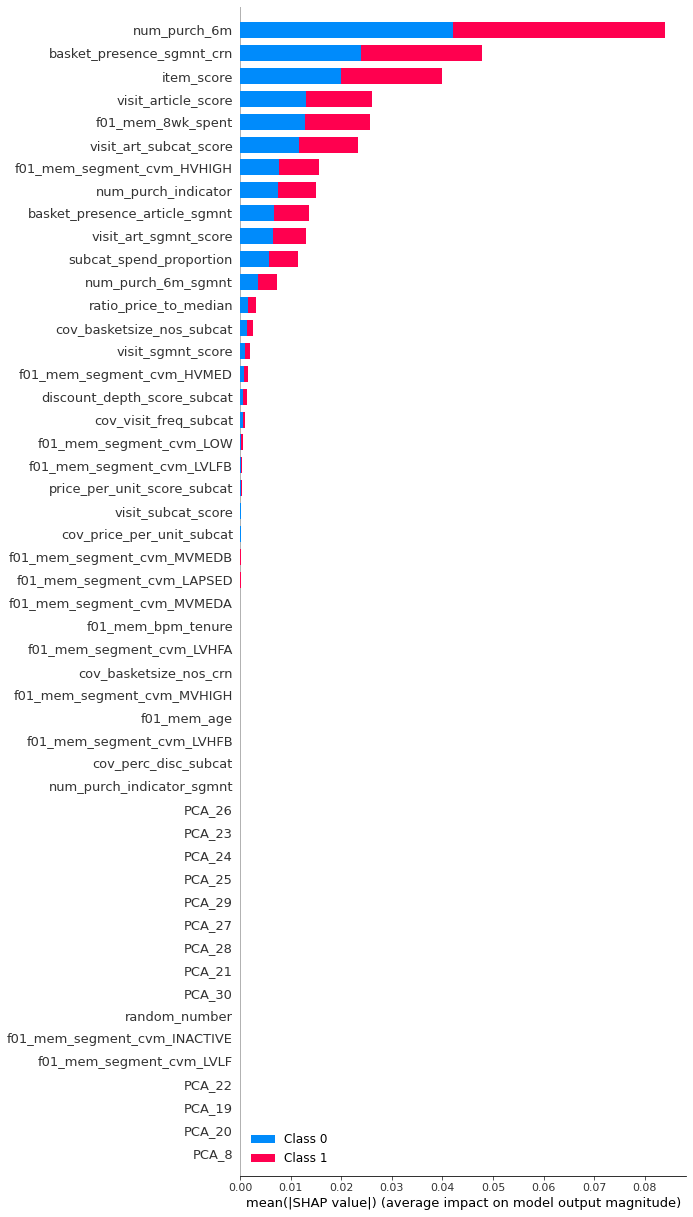

In [46]:
model_lgb_AKL.params['objective'] = 'binary'
plot_shap_importance(model_lgb_AKL, X_train.drop("sample_weight", axis="columns"), list(X_train_column_labels).remove("sample_weight"))    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

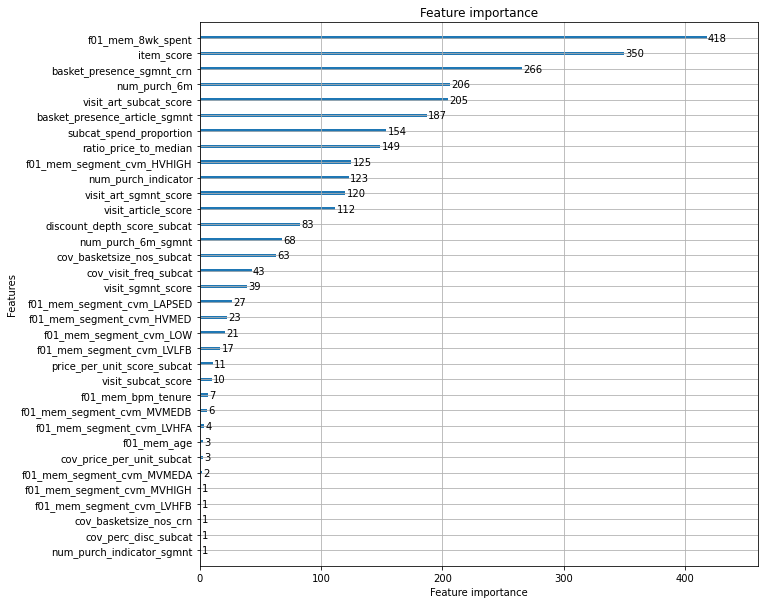

In [41]:
lgb.plot_importance(model_lgb_AKL,figsize=(10, 10))

## Use default hyper parameters

In [47]:
param = {'objective': 'binary', 'metric':['auc', 'binary_logloss']}
num_round = 1000

model_lgb_default = lgb.train(param, train_data, num_round,
                valid_sets=valid_data, callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Number of positive: 8000086, number of negative: 7998958
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.409344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13312
[LightGBM] [Info] Number of data points in the train set: 15999044, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007869 -> initscore=-4.836973
[LightGBM] [Info] Start training from score -4.836973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.948082	valid_0's binary_logloss: 0.0246373


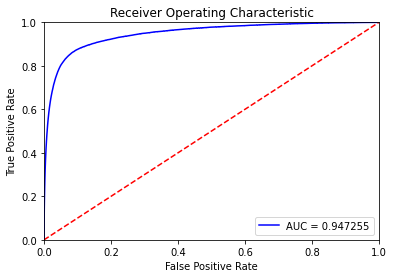

In [48]:
plot_ROC_AUC(y_test, model_lgb_default.predict(X_test.drop("sample_weight", axis="columns")))

In [ ]:
# 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


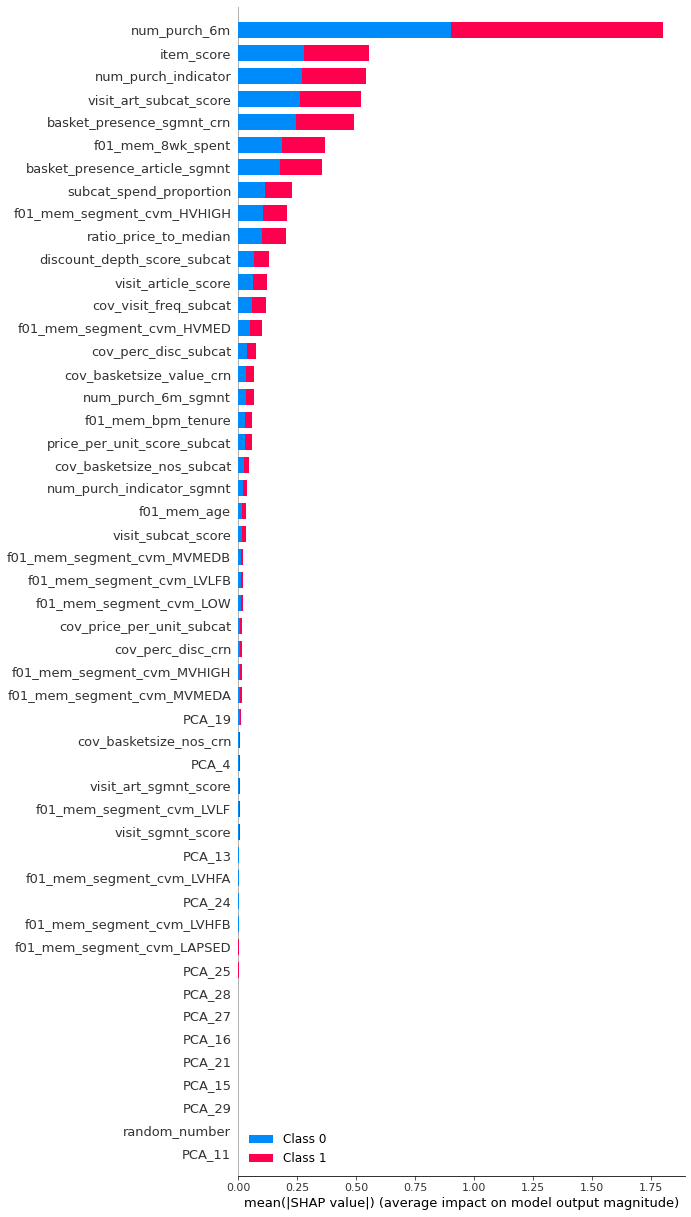

In [49]:
plot_shap_importance(model_lgb_default, X_train.drop("sample_weight", axis="columns"), list(X_train_column_labels).remove("sample_weight"))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

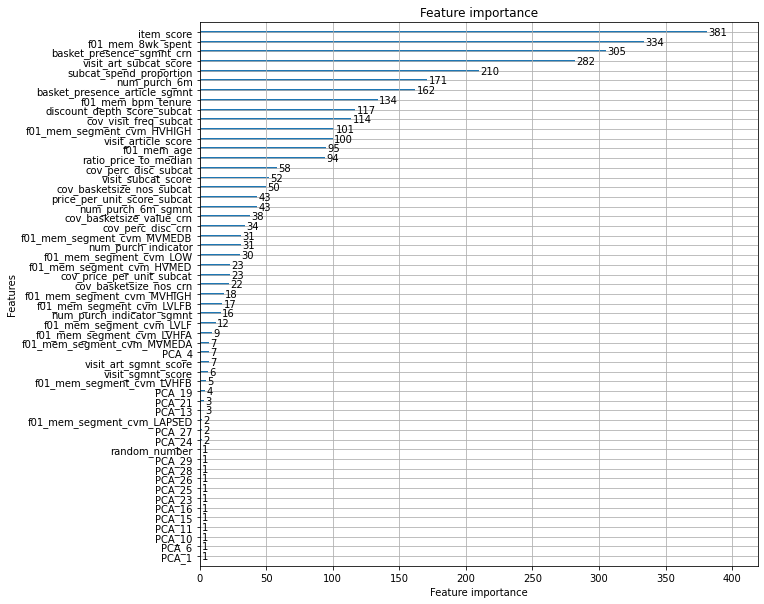

In [72]:
lgb.plot_importance(model_lgb_default,figsize=(10, 10))

(array([1.512953e+07, 2.518750e+05, 1.944540e+05, 9.976400e+04,
        2.270330e+05, 9.523500e+04, 6.930000e+02, 3.910000e+02,
        6.400000e+01, 5.000000e+00]),
 array([1.11111111e+01, 3.56965021e+03, 7.12818930e+03, 1.06867284e+04,
        1.42452675e+04, 1.78038066e+04, 2.13623457e+04, 2.49208848e+04,
        2.84794239e+04, 3.20379630e+04, 3.55965021e+04]),
 <BarContainer object of 10 artists>)

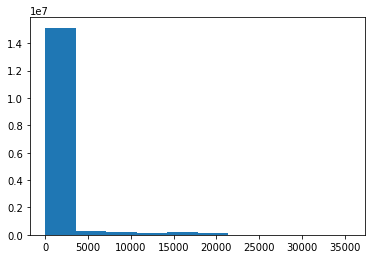

In [53]:
plt.hist(X_train.sample_weight)

(array([     0.,      0.,      0.,      0.,      0., 596611.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

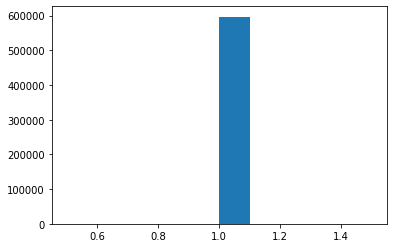

In [54]:
plt.hist(X_valid.sample_weight)

(array([      0.,       0.,       0.,       0.,       0., 3611672.,
              0.,       0.,       0.,       0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

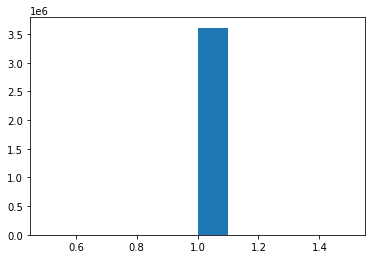

In [55]:
plt.hist(X_test.sample_weight)